# Auto complete the skill point maximizer forms

## OCR of skill hints (test)

In [1]:
import pytesseract
from PIL import Image

img = Image.open('test.png')
img = img.convert('RGB')
size = img.size

border = 750
for x in range(size[0]):
  for y in range(size[1]):
    r,g,b = img.getpixel((x,y))
    if r + g + b > border:
      r, g, b = 255, 255, 255
    else:
      r, g, b = 0, 0, 0
    img.putpixel((x,y), (r,g,b))

img.show()

txt = pytesseract.image_to_string(img,lang='jpn')
txt = txt.replace(' ', '')
print(txt)

ヒントLv2
20%0FF

ヒントLv1
10%O0FF



## Preliminary

In [2]:
BLACK = 0
WHITE = 255

### Display function

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import collections

In [154]:
def imgshow(src, portrait=False):
  if type(src) is list:
    list_src = src
  else:
    list_src = [src]
  if not portrait:
    fig = plt.figure(figsize = (8*len(list_src), 16))
    subplot_layout = (1, len(list_src))
  else:
    fig = plt.figure(figsize = (16, 4*len(list_src)))
    subplot_layout = (len(list_src), 1)
  for i, img in enumerate(list_src, 1):
    ax = fig.add_subplot(subplot_layout[0], subplot_layout[1], i)
    if img.ndim == 2: # gray scale
      ax.imshow(img, cmap='gray', vmin=0, vmax=255)
    elif img.shape[2] == 3: # BGR
      ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    elif img.shape[2] == 4: # BGRA
      ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGBA))

## Analyze images and extract skill hint information

### Display search regions for cropping margins

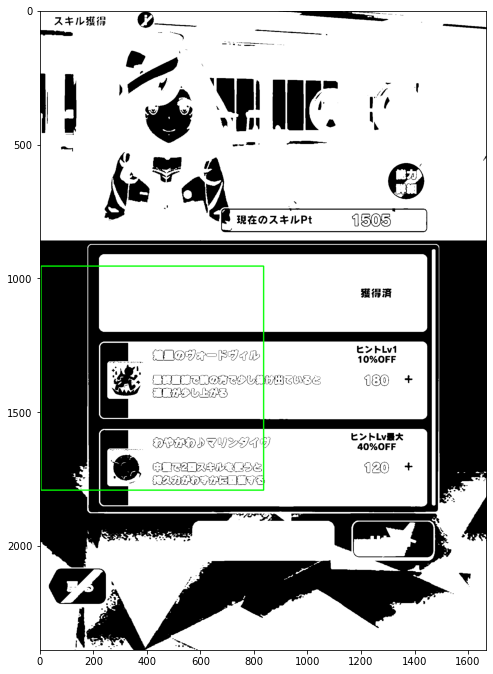

In [88]:
img_number = 1
# img = cv2.imread(f'mtknt{img_number}.jpg', cv2.IMREAD_COLOR) # for iPhone
img = cv2.imread(f'iPad{img_number}.png', cv2.IMREAD_COLOR) # for iPad

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL)
height_orig, width_orig, _ = img.shape

# digitization thresholds in HSV
min = (0, 0, 0)
max = (255, 255, 245)
inrange = cv2.inRange(hsv, min, max)

tmp_img = cv2.cvtColor(inrange, cv2.COLOR_GRAY2BGR)
cv2.rectangle(tmp_img, pt1=(3, int(height_orig*0.4)),
  pt2=(int(width_orig*0.5), int(height_orig*0.75)),
  color=(0,255,0),thickness=3)
imgshow(tmp_img)

### Detect margin left

検出されたX座標と回数
[(177, 524), (176, 216), (133, 13), (147, 9), (148, 7)]

余白座標; 左:177, 右:1491

赤い点が検出箇所


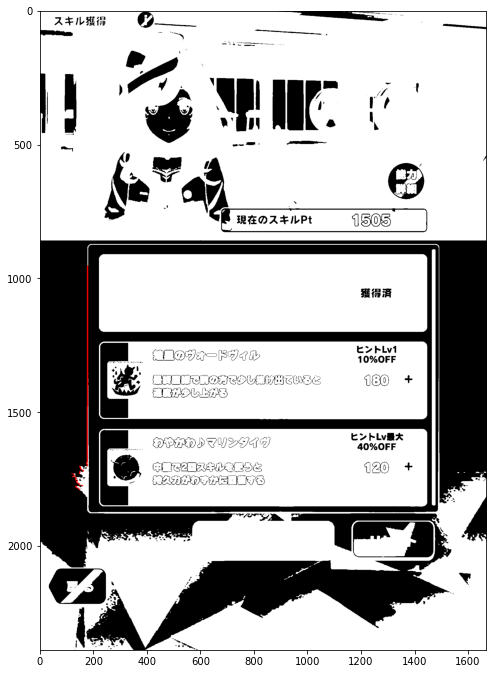

In [68]:
positions = []
tmp_img = cv2.cvtColor(inrange, cv2.COLOR_GRAY2BGR)

for y in np.arange(int(height_orig*0.4), int(height_orig*0.75)):
  for x in np.arange(1, int(width_orig*0.5)):
    if inrange[y,x] == WHITE:
      positions.append(x)
      cv2.line(tmp_img, pt1=(x,y), pt2=(x,y),
        color=(0,0,255), thickness=3)
      break

c = collections.Counter(positions)
print('検出されたX座標と回数')
print(c.most_common(5))

margin_left = c.most_common(1)[0][0]
margin_right = width_orig - margin_left
width = margin_right - margin_left
print(f'\n余白座標; 左:{margin_left}, 右:{margin_right}')

print('\n赤い点が検出箇所')
imgshow(tmp_img)

### For check of margin sides

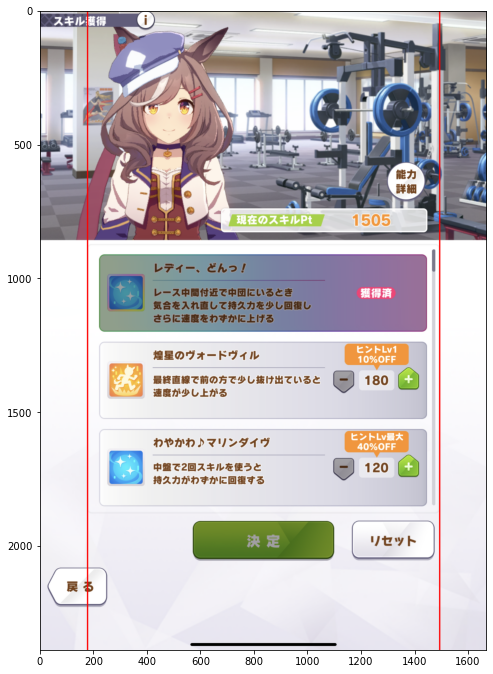

In [69]:
tmp_img = img.copy()
cv2.line(tmp_img, pt1=(margin_left, 0), pt2=(margin_left, height_orig),
  color=(0,0,255), thickness=3)
cv2.line(tmp_img, pt1=(margin_right, 0), pt2=(margin_right, height_orig),
color=(0,0,255), thickness=3)
imgshow(tmp_img)

### Display search region for margin top

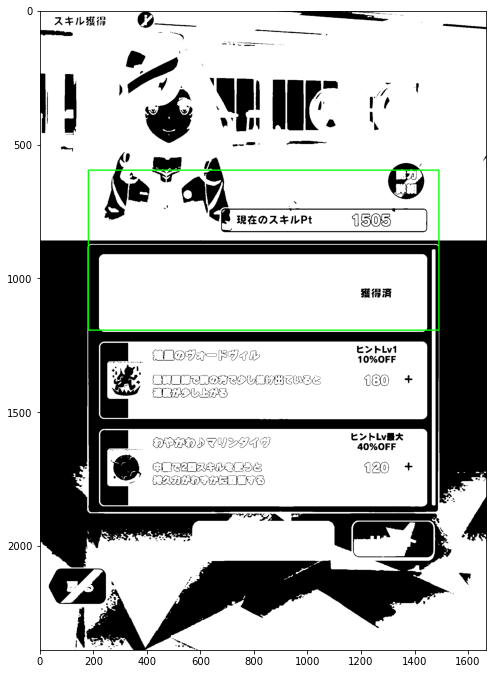

In [101]:
# green box shows search range
tmp_img = cv2.cvtColor(inrange, cv2.COLOR_GRAY2BGR)
cv2.rectangle(tmp_img, pt1=(margin_left+3, int(height_orig*0.25)),
  pt2=(margin_right-3, int(height_orig*0.50)),
  color=(0,255,0), thickness=3)
imgshow(tmp_img)

### Margin top detection and display

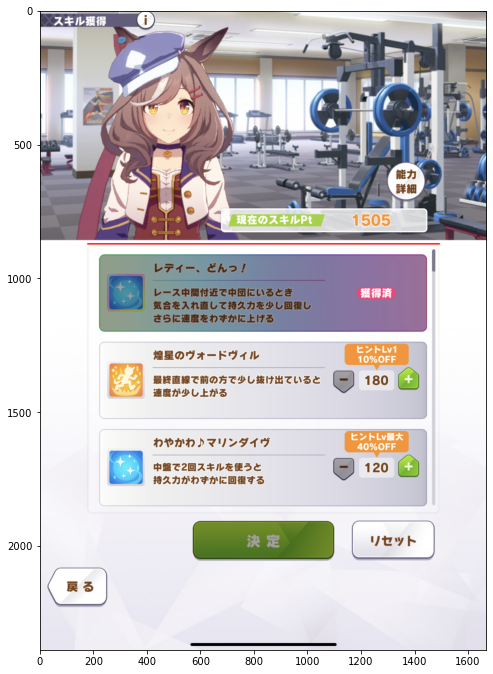

In [100]:
min_ratio = 0.9
max_ratio = 1.1
after_black = False
for y in np.arange(int(height_orig*0.25), int(height_orig*0.50)):
  if not after_black:
    cts = np.count_nonzero(inrange[y, margin_left:margin_right] == BLACK)
    ratio = cts / width
    if min_ratio < ratio and ratio < max_ratio:
      after_black = True
  else:
    cts = np.count_nonzero(inrange[y, margin_left:margin_right] == WHITE)
    ratio = cts / width
    if min_ratio < ratio and ratio < max_ratio:
      margin_top = y-1
      break

tmp_img = img.copy()
cv2.line(tmp_img, pt1=(margin_left, margin_top), pt2=(margin_right, margin_top),
  color=(0, 0, 255), thickness=3)
imgshow(tmp_img)

### Display search range for margin bottom

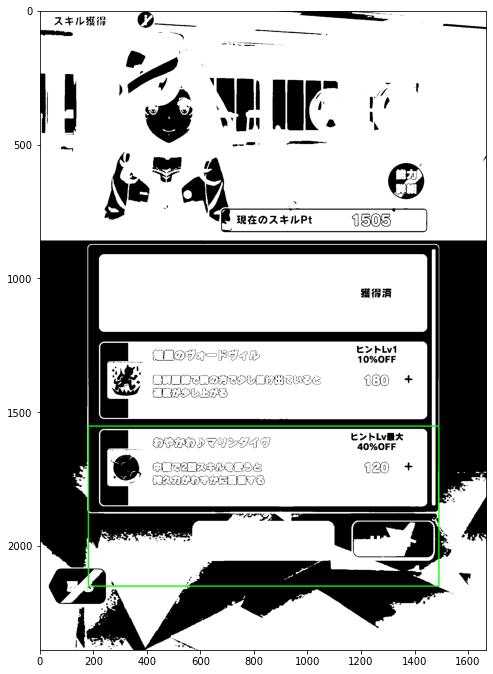

In [84]:
# green box shows search range
tmp_img = cv2.cvtColor(inrange, cv2.COLOR_GRAY2BGR)
cv2.rectangle(tmp_img, pt1=(margin_left+3, int(height_orig*0.65)),
  pt2=(margin_right-3, int(height_orig*0.90)),
  color=(0,255,0), thickness=3)
imgshow(tmp_img)

### Margin bottom detection and display

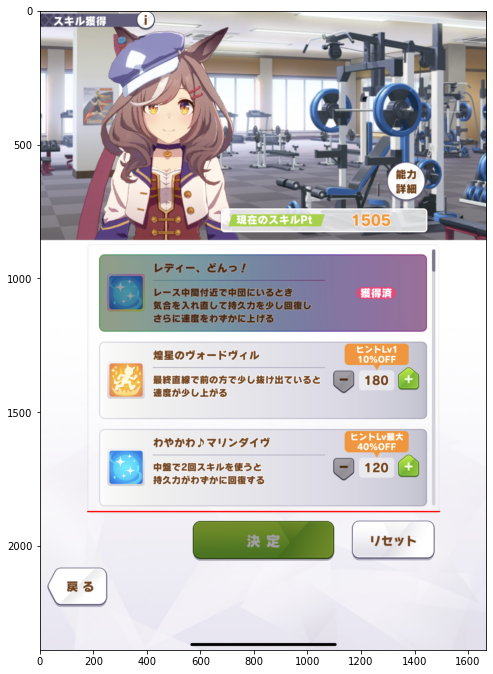

In [71]:
min_ratio = 0.4
max_ratio = 0.8
for y in np.arange(int(height_orig*0.65), int(height_orig*0.9)):
  cts = np.count_nonzero(inrange[y, margin_left:margin_right] == BLACK)
  ratio = cts / width
  if min_ratio < ratio and ratio < max_ratio:
    margin_bottom = y-1
    break

tmp_img = img.copy()
cv2.line(tmp_img, pt1=(margin_left, margin_bottom), pt2=(margin_right, margin_bottom),
  color=(0, 0, 255), thickness=3)
imgshow(tmp_img)

### Display search region for template match

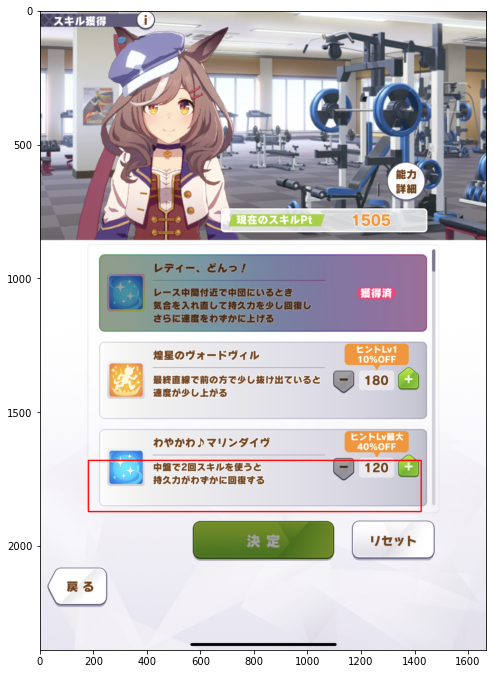

In [72]:
tmp_img = img.copy()
skill_height = int(height_orig*0.08)
skill_right = margin_left + int((margin_right - margin_left) * 0.95)
cv2.rectangle(tmp_img, pt1=(margin_left+3, margin_bottom-skill_height),
  pt2=(skill_right-3, margin_bottom), color=(0,0,255), thickness=3)
imgshow(tmp_img)

### Crop image with the above rectangle

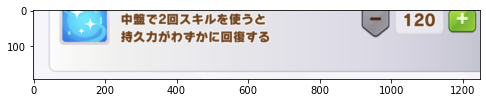

In [73]:
skill_img = img[margin_bottom-skill_height:margin_bottom, margin_left:skill_right]
imgshow(skill_img)

### Template match

グレースケール画像

テンプレートマッチ結果
-0.26158449053764343 0.992061197757721 (420, 1818) (177, 1016)

類似度が最も高い場所

結合用に切り抜き


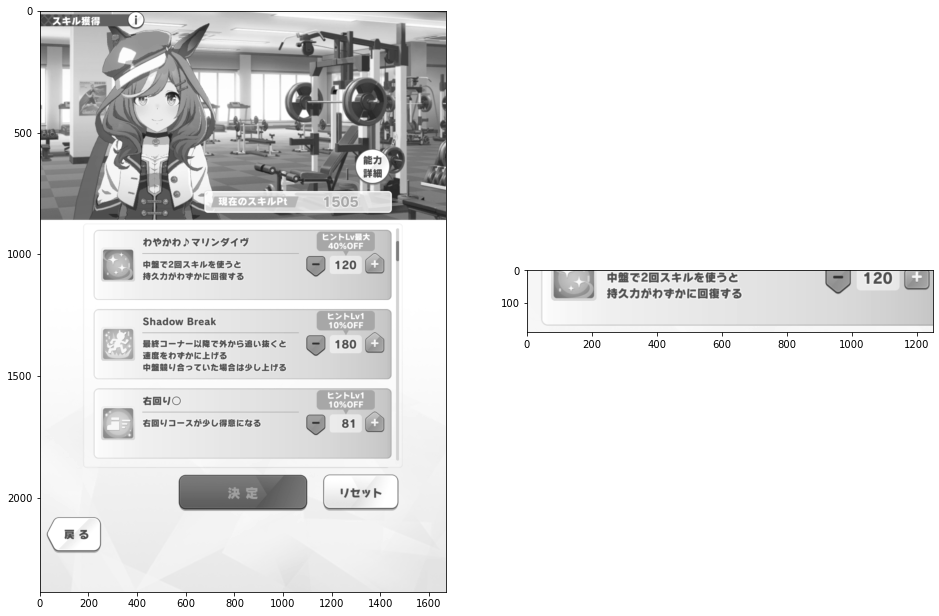

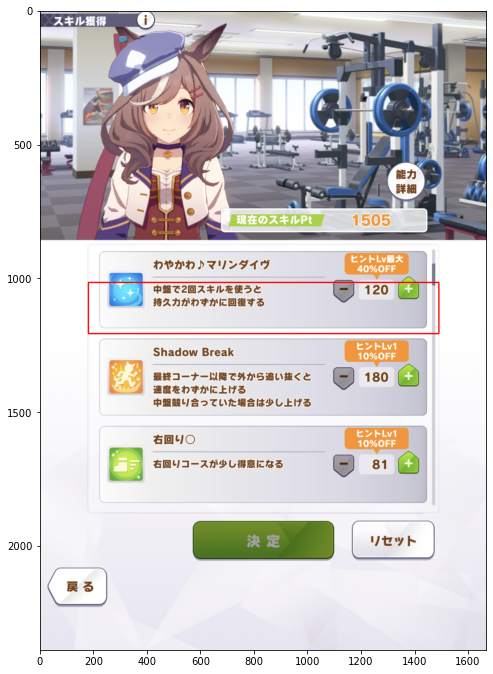

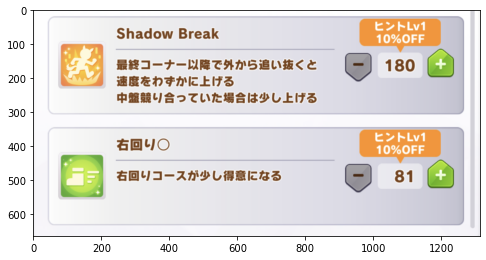

In [107]:
# img2 = cv2.imread(f'mtknt{img_number+1}.jpg', cv2.IMREAD_COLOR) # for iPhone
img2 = cv2.imread(f'iPad{img_number+1}.png', cv2.IMREAD_COLOR) # for iPad

# gray scale
img_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
skill_gray = cv2.cvtColor(skill_img, cv2.COLOR_BGR2GRAY)
print('グレースケール画像')
imgshow([img_gray, skill_gray])

# template match
res = cv2.matchTemplate(img_gray, skill_gray, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
print('\nテンプレートマッチ結果')
print(min_val, max_val, min_loc, max_loc)

# display the result
tmp_img = img2.copy()
cv2.rectangle(tmp_img, pt1=(max_loc[0]+3, max_loc[1]),
  pt2=(max_loc[0]+width-3, max_loc[1]+skill_height), color=(0,0,255), thickness=3)
print('\n類似度が最も高い場所')
imgshow(tmp_img)

# crop
clip_img = img2[max_loc[1]+skill_height:margin_bottom,margin_left:margin_right]
print('\n結合用に切り抜き')
imgshow(clip_img)

### Combine clip images

結合結果


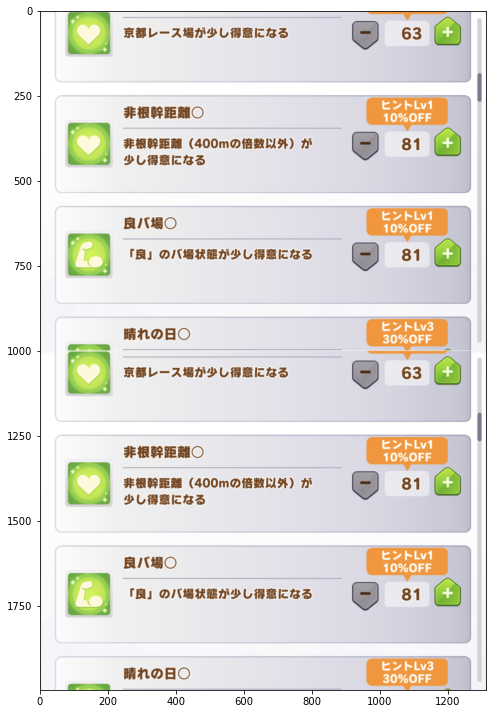

In [124]:
clip_imgs = []
clip_imgs.append(img[margin_top:margin_bottom,margin_left:margin_right])
clip_imgs.append(clip_img)

height_total = sum(c.shape[0] for c in clip_imgs)
output_img = np.zeros((height_total, width, 3), dtype=np.uint8)
y = 0
for clip_img in clip_imgs:
  output_img[y:y+clip_img.shape[0],:] = clip_img
  y += clip_img.shape[0]
print('結合結果')
imgshow(output_img)

### Function for combining images

In [134]:
def combine_images(images, preview=False):

  # digitization thresholds in HSV
  min = (0, 0, 0)
  max = (255, 255, 245)

  # digitization
  img = images[0]
  height_orig, width_orig, _ = img.shape
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL)
  inrange = cv2.inRange(hsv, min, max)

  # search left most white points for side margin detection
  positions = []
  for y in np.arange(int(height_orig*0.4), int(height_orig*0.75)):
    for x in np.arange(1, int(width_orig*0.5)):
      if inrange[y,x] == WHITE:
        positions.append(x)
        cv2.line(tmp_img, pt1=(x,y), pt2=(x,y),
          color=(0,0,255), thickness=3)
        break

  # side margin detection
  c = collections.Counter(positions)
  margin_left = c.most_common(1)[0][0]
  margin_right = width_orig - margin_left
  width = margin_right - margin_left

  # threshold of white dots ratio for the margin region
  min_ratio = 0.9
  max_ratio = 1.1

  # margin top detection
  after_black = False
  for y in np.arange(int(height_orig*0.25), int(height_orig*0.50)):
    if not after_black:
      cts = np.count_nonzero(inrange[y, margin_left:margin_right] == BLACK)
      ratio = cts / width
      if min_ratio < ratio and ratio < max_ratio:
        after_black = True
    else:
      cts = np.count_nonzero(inrange[y, margin_left:margin_right] == WHITE)
      ratio = cts / width
      if min_ratio < ratio and ratio < max_ratio:
        margin_top = y-1
        break

  # threshold of black dots ratio for the margin bottom
  min_ratio = 0.4
  max_ratio = 0.8

  # margin bottom detection
  for y in np.arange(int(height_orig*0.65), int(height_orig*0.9)):
    cts = np.count_nonzero(inrange[y, margin_left:margin_right] == BLACK)
    ratio = cts / width
    if min_ratio < ratio and ratio < max_ratio:
      margin_bottom = y-1
      break

  # list of clipped images
  clip_imgs = []
  clip_imgs.append(img[margin_top:margin_bottom,margin_left:margin_right])

  # region used for template matching
  skill_height = int(height_orig*0.08)
  skill_right = margin_left + int((margin_right - margin_left)*0.95)

  for i in np.arange(1,len(images)):

    # clip bottom region of the old image
    skill_img = img[margin_bottom-skill_height:margin_bottom, margin_left:skill_right]

    # new image
    img = images[i]

    # template match
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    skill_gray = cv2.cvtColor(skill_img, cv2.COLOR_BGR2GRAY)
    res = cv2.matchTemplate(img_gray, skill_gray, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # crop
    clip_img = img[max_loc[1]+skill_height:margin_bottom,margin_left:margin_right]
    clip_imgs.append(clip_img)

  # combine clipped images
  height_total = sum(c.shape[0] for c in clip_imgs)
  output_img = np.zeros((height_total, width, 3), dtype=np.uint8)
  y = 0
  for clip_img in clip_imgs:
    output_img[y:y+clip_img.shape[0],:] = clip_img
    y += clip_img.shape[0]

  # preview combine result
  if preview:
    print('結合結果')
    imgshow(output_img)
  
  return output_img

### Read all images

In [161]:
def read_images(num_images, prefix, extension='png', preview=False):
  images = []
  for i in np.arange(1,num_images+1):
    img = cv2.imread(prefix+str(i)+'.'+extension, cv2.IMREAD_COLOR) # for iPad
    print(f'{i-i0+1}枚目: {img.shape[1]}px x {img.shape[1]}px')
    if i > i0:
      if(images[i-i0-1].shape[0] != img.shape[0]) | (images[i-i0-1].shape[1] != img.shape[1]):
        raise Exception('異なる解像度の画像が入力されています')
    images.append(img)

  if preview:
    imgshow(images)

  return images

### Test: read images and preview

1枚目: 1668px x 1668px
2枚目: 1668px x 1668px
3枚目: 1668px x 1668px
4枚目: 1668px x 1668px


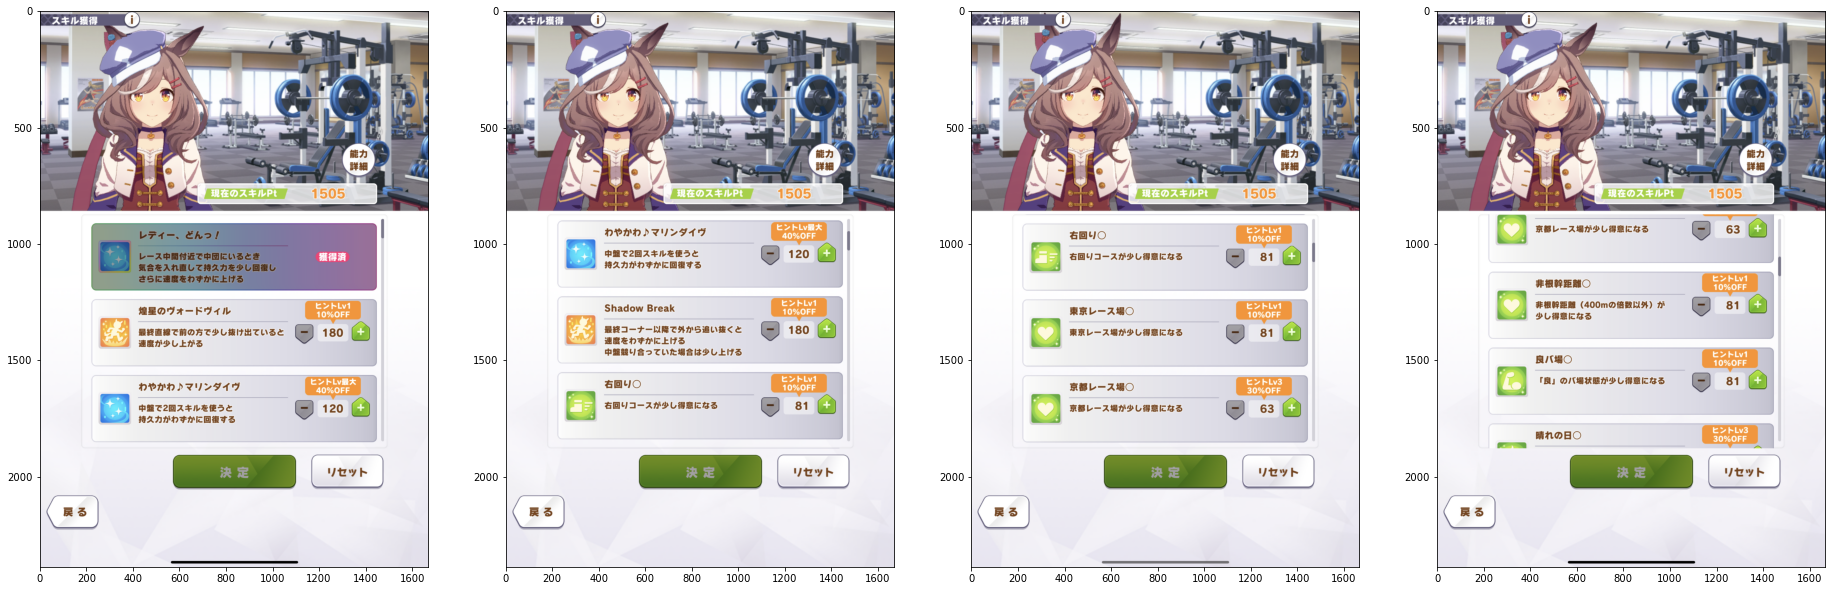

In [168]:
# images = read_images(13, 'mtknt', extension='jpg', preview=True) # for iPhone
images = read_images(4, 'iPad', preview=True) # for iPad

### Test: combine

結合結果


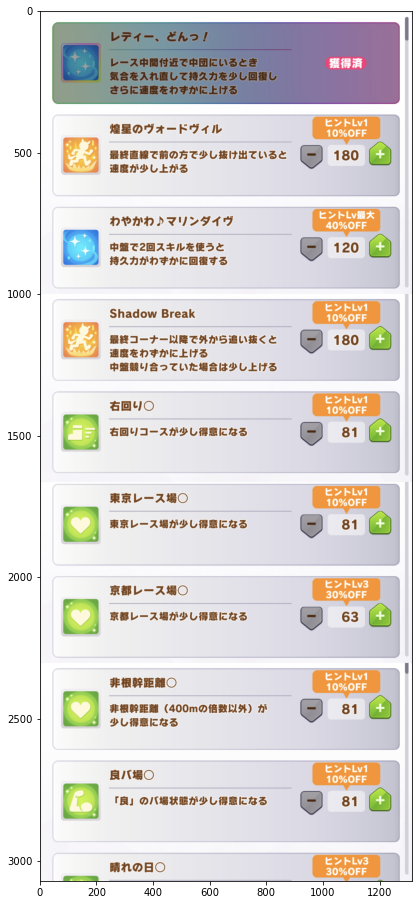

In [169]:
combined_img = combine_images(images, preview=True)

### Crop image with white background as delimiter

In [164]:
def crop_delim_white(img):

  # average color per row of grayed image is used to judge white BG
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  average_color_per_row = np.average(gray_img, axis=1)
  is_white = average_color_per_row > 240

  # image with white for all skill box regions and black for others
  skill_box_regions = gray_img
  for y in range(len(img)):
    if is_white[y]:
      skill_box_regions[y] = np.full(len(img[0]), 0)
    else:
      skill_box_regions[y] = np.full(len(img[0]), 255)

  # contours of skill box regions
  _, threshold_img = cv2.threshold(skill_box_regions, 180, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(threshold_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # crop image according to contours
  images = []
  for contour in reversed(contours): # reverse to recover the original ordering
    x, y, w, h = cv2.boundingRect(contour)
    cropped_img = img[y:y+h, x:x+w]
    images.append(cropped_img)
    
  return images

### Test: divide combined image into each skill

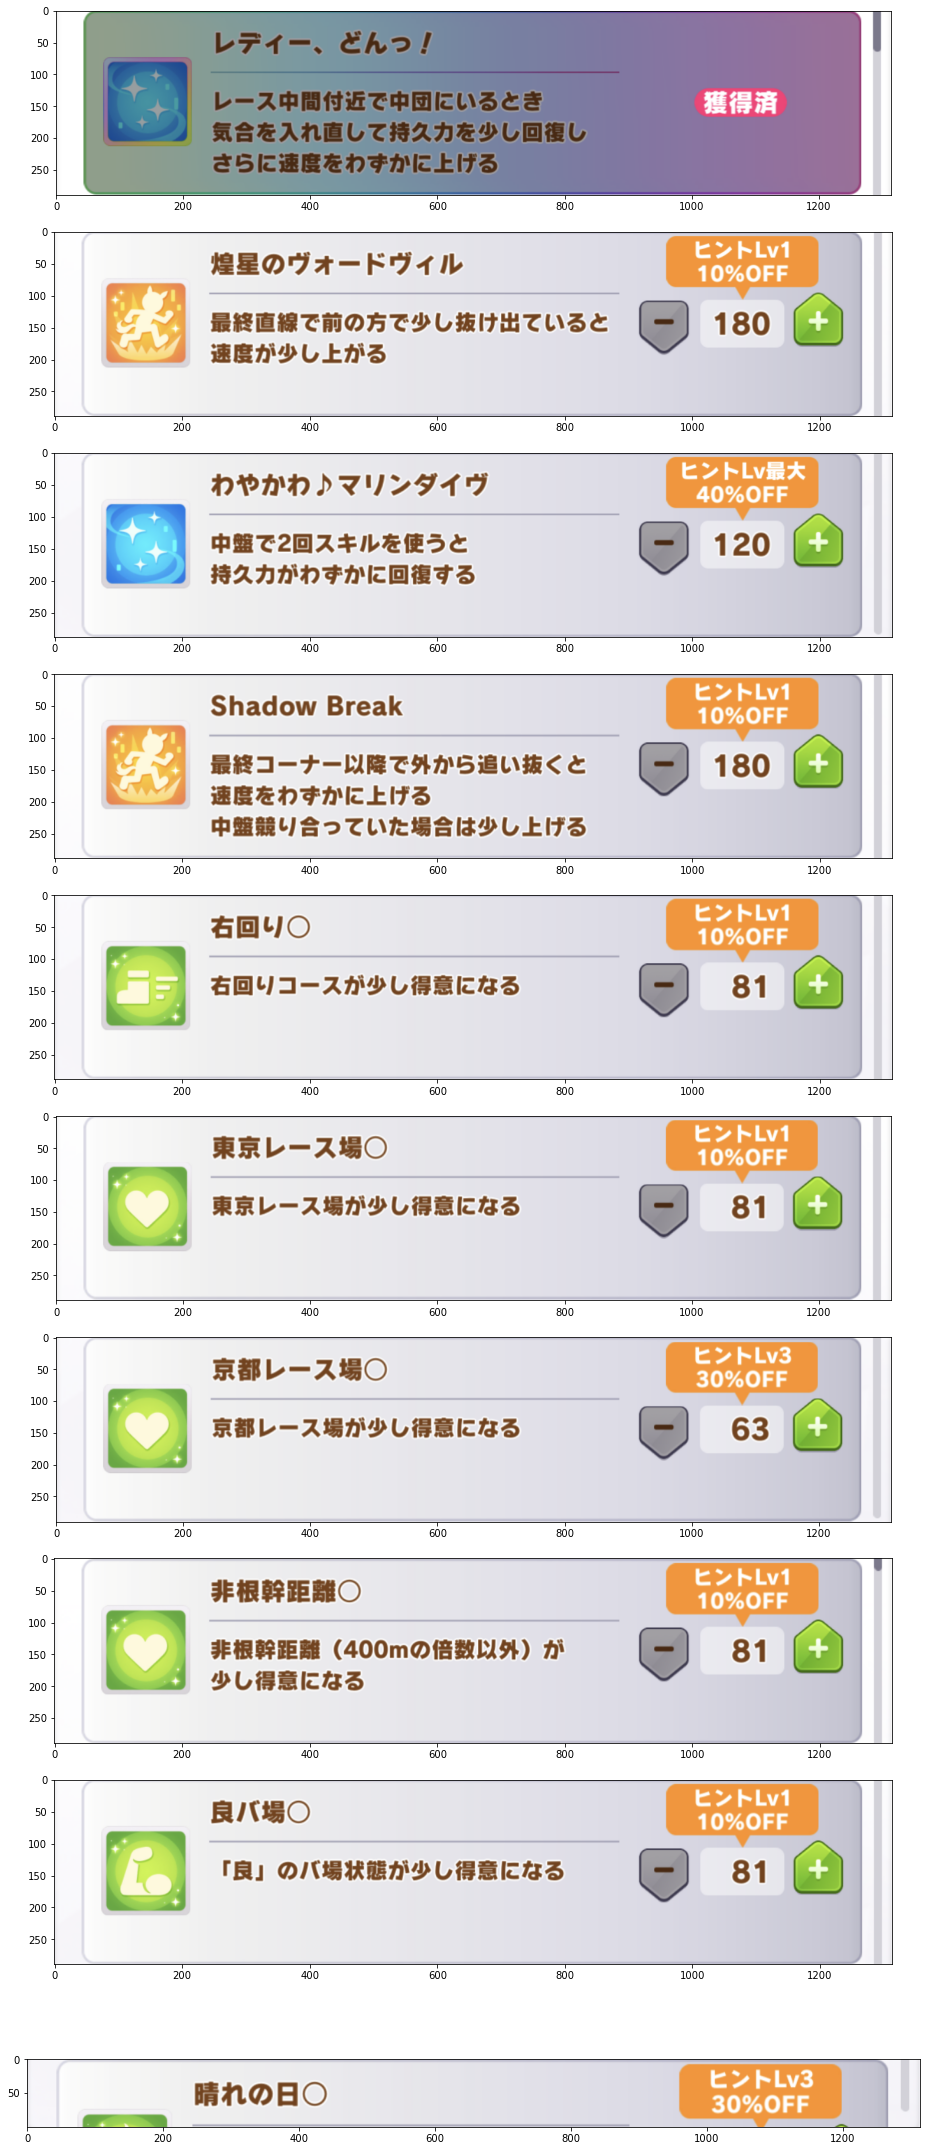

In [170]:
skill_imgs = crop_delim_white(combined_img)
imgshow(skill_imgs, portrait=True)

### Judge if unavailable, gold, or normal skill

In [171]:
border_gray = 180
border_blue = 180
for skill in skill_imgs:
  gray_skill = cv2.cvtColor(skill, cv2.COLOR_BGR2GRAY)
  if np.median(gray_skill) < border_gray:
    print('取得済み or スキルポイント不足')
  else:
    print('未取得')
    if(np.median(skill[:,:,0]) < border_blue):
      print('金スキル')
    else:
      print('ノーマルスキル')

取得済み or スキルポイント不足
未取得
ノーマルスキル
未取得
ノーマルスキル
未取得
ノーマルスキル
未取得
ノーマルスキル
未取得
ノーマルスキル
未取得
ノーマルスキル
未取得
ノーマルスキル
未取得
ノーマルスキル
未取得
ノーマルスキル


### Extract hint level

In [78]:
img = cv2.imread('test3.png')
skill_boxes = crop_delim_white(img)
skill_cv = skill_boxes[0]

gray_skill_cv = cv2.cvtColor(skill_cv, cv2.COLOR_BGR2GRAY)
gray_skill = Image.fromarray(gray_skill_cv)
size = gray_skill.size

border = 253
for x in range(size[0]):
  for y in range(size[1]):
    c = gray_skill.getpixel((x,y))
    if c > border:
      c = 255
    else:
      c = 0
    gray_skill.putpixel((x,y), c)

gray_skill.show()

txt = pytesseract.image_to_string(gray_skill,lang='jpn')
txt = txt.replace(' ', '')
print(txt)

ヒントLv1
102oOFF



## Auto complete skill hints

In [70]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

options = Options()
options.add_argument('--disable-gpu')
options.add_argument('--disable-extensions')
options.add_argument('--proxy-server="direct://"')
options.add_argument('--proxy-bypass-list=*')
options.add_argument('--start-maximized')

DRIVER_PATH = '/usr/local/bin/chromedriver'
driver = webdriver.Chrome(executable_path=DRIVER_PATH, options=options)

load_url = 'https://gamewith.jp/uma-musume/article/show/293663'
driver.get(load_url)

<ipython-input-70-8c7b64c92cfd>:13: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=DRIVER_PATH, options=options)


### 現在のスキルポイントを入力

In [71]:
skill_point = 2000
skill_point_textarea = driver.find_element(By.XPATH, "//input[@id='HavePoint'][@type='number']")
skill_point_textarea.send_keys(str(skill_point))

### 切れ者を取得している

In [72]:
shrewd = True
if shrewd:
  shrewd_checkbox = driver.find_element(By.XPATH, "//label[@for='HasKiremono']")
  shrewd_checkbox.click()

### 適性を入力する

In [73]:
appropriate = [1,4,3,2,1,1,1,2,3,4] # 1 [SA] 2 [BC] 3 [DEF] 4[G]
for count, app in enumerate(appropriate): # grass, dart, sprint, mile, middle, long, front, stalk, stay, off
  id = "//label[@for='AppropriateSelect" + str(count+1) + "_" + str(app) + "']"
  appropriate_radio = driver.find_element(By.XPATH, id)
  appropriate_radio.click()

### 取得しているヒントとレベル

In [74]:
hints = [['VIP顔パス', 2],['アガッてきた！', 4]]
for hint in hints:
  hint_search_textarea = driver.find_element(By.XPATH, "//input[@id='SkillSearchText'][@type='text']")
  hint_search_textarea.clear()
  hint_search_textarea.send_keys(hint[0])
  skill_label = driver.find_element(By.XPATH, '//*[@id="article-body"]/div[3]/div[2]/ol[2]/li/label')
  skill_label.click() # スキルヒントLv.0取得
  hint_up_button = driver.find_element(By.XPATH, '//*[@class="_hint-button is-up"]')
  for i in range(hint[1]): # ヒントLv.設定
    hint_up_button.click()

### 評価点が最大になる組み合わせを計算

In [76]:
maximizer_button = driver.find_element(By.XPATH, '//*[@class="w-start-calculate js-start-calculate"]')
maximizer_button.click()

In [ ]:
# driver.quit()